In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, log_loss, confusion_matrix

In [4]:
bnk = pd.read_csv("bank.csv", sep=';')
print(bnk.shape)
bnk.head(3)

(41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [55]:
bnk.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41184.000000,41184.000000,41184.000000,41184.000000,41184.000000,41184.00000,41184.000000,41184.000000,41184.000000,41184.000000
mean,40.023529,258.310096,2.567381,962.471907,0.172980,0.08192,93.575686,-40.502508,3.621337,5167.037145
std,10.421044,259.279344,2.769895,186.919638,0.494922,1.57096,0.578849,4.628128,1.734438,72.252762
min,17.000000,1.000000,1.000000,0.000000,0.000000,-3.40000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,102.000000,1.000000,999.000000,0.000000,-1.80000,93.075000,-42.700000,1.344000,5099.100000
50%,38.000000,180.000000,2.000000,999.000000,0.000000,1.10000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,319.000000,3.000000,999.000000,0.000000,1.40000,93.994000,-36.400000,4.961000,5228.100000
max,98.000000,4918.000000,56.000000,999.000000,7.000000,1.40000,94.767000,-26.900000,5.045000,5228.100000


In [5]:
cat_feat1 = ['default', 'housing', 'loan']
cat_feat2 = ['job','marital', 'education', 'contact', 'month', 'day_of_week', 'poutcome']
cat_feat = cat_feat1 + cat_feat2
cont_feat = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'euribor3m', 'nr.employed']

In [6]:
for ftr in cat_feat1:
    bnk.loc[bnk[ftr] == 'yes', ftr] = 1
    bnk.loc[bnk[ftr] == 'no', ftr] = 0
    bnk.loc[bnk[ftr] == 'unknown', ftr] = 0

In [7]:
bnk.loc[bnk['y'] == 'yes', 'y'] = 1
bnk.loc[bnk['y'] == 'no', 'y'] = 0

In [8]:
for ftr in cat_feat2:
    feat_list = bnk[ftr].unique()
    i = 1
    for n in feat_list:
        bnk.loc[bnk[ftr] == n, ftr] = i
        i += 1

In [9]:
bnk.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,1,1,1,0,0,0,1,1,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
1,57,2,1,2,0,0,0,1,1,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
2,37,2,1,2,0,1,0,1,1,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
3,40,3,1,3,0,0,0,1,1,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
4,56,2,1,2,0,0,1,1,1,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0


In [10]:
#Убираем те случаи, когда длительность звонка равна нулю, так как это означает, что целевой признак будет 0
bnk = bnk.drop(bnk[bnk['duration'] == 0].index, 0)

In [11]:
bnk[cat_feat] = bnk[cat_feat].astype('int')

In [12]:
X_train, X_test, y_train, y_test = train_test_split(bnk.drop('y', 1), bnk['y'], random_state=0)

In [13]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30888 entries, 19295 to 2732
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             30888 non-null  int64  
 1   job             30888 non-null  int32  
 2   marital         30888 non-null  int32  
 3   education       30888 non-null  int32  
 4   default         30888 non-null  int32  
 5   housing         30888 non-null  int32  
 6   loan            30888 non-null  int32  
 7   contact         30888 non-null  int32  
 8   month           30888 non-null  int32  
 9   day_of_week     30888 non-null  int32  
 10  duration        30888 non-null  int64  
 11  campaign        30888 non-null  int64  
 12  pdays           30888 non-null  int64  
 13  previous        30888 non-null  int64  
 14  poutcome        30888 non-null  int32  
 15  emp.var.rate    30888 non-null  float64
 16  cons.price.idx  30888 non-null  float64
 17  cons.conf.idx   30888 non-nu

In [14]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion

In [16]:
base_feat = ['default', 'housing', 'loan', 'contact']
cat_feat = ['job', 'marital', 'education', 'month', 'day_of_week', 'poutcome']
cont_feat = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'euribor3m', 'nr.employed']

In [17]:
# Добавляем
final_transformers = list()

for cat_col in cat_feat:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in cont_feat:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                #('standard', StandardScaler(cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))
    
for base_col in base_feat:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    final_transformers.append((base_col, base_transformer))

In [18]:
X_train

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
19295,53,5,1,2,0,1,0,2,4,3,329,1,999,0,1,1.4,93.444,-36.1,4.967,5228.1
155,36,4,1,4,0,1,1,1,1,1,98,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0
19999,42,9,1,7,0,0,0,2,4,5,1206,4,999,0,1,1.4,93.444,-36.1,4.966,5228.1
30931,48,4,1,4,0,1,0,2,1,2,88,2,999,0,1,-1.8,92.893,-46.2,1.344,5099.1
17085,42,4,2,1,0,1,1,2,3,5,107,4,999,0,1,1.4,93.918,-42.7,4.962,5228.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20758,47,3,1,5,0,1,0,2,4,3,136,2,999,0,1,1.4,93.444,-36.1,4.965,5228.1
32106,45,5,1,4,0,0,1,2,1,5,1077,1,999,0,1,-1.8,92.893,-46.2,1.313,5099.1
30406,61,6,3,7,0,0,0,2,9,4,949,2,999,0,1,-1.8,93.075,-47.1,1.365,5099.1
21244,47,3,1,7,0,0,1,2,4,1,471,1,999,0,1,1.4,93.444,-36.1,4.963,5228.1


In [19]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

import itertools
import matplotlib.pyplot as plt

%matplotlib inline

In [20]:
model = xgboost.train({"learning_rate": 0.01}, 
                      xgboost.DMatrix(X_train, label=y_train), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

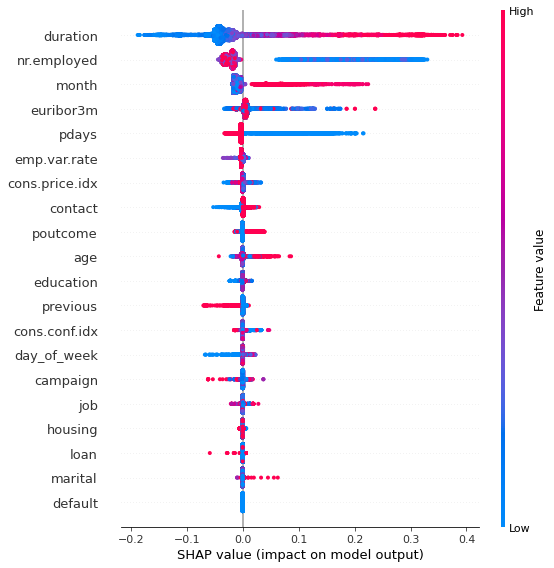

In [21]:
shap.summary_plot(shap_values, X_train)

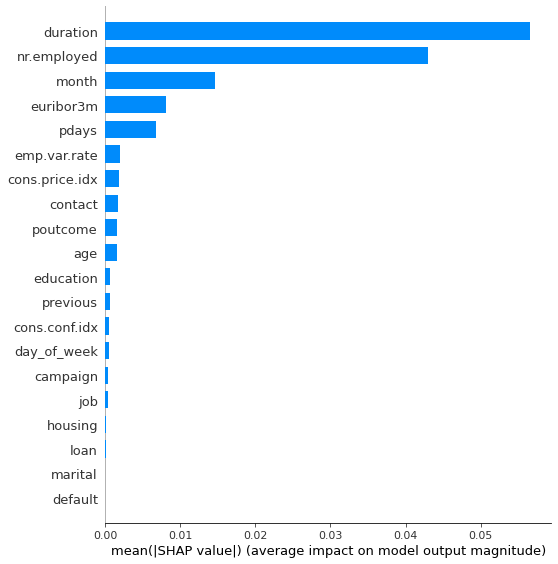

In [22]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [23]:
n = 30
shap.initjs() 
shap.force_plot(explainer.expected_value, shap_values[:n,:], X_train.iloc[:n,:])

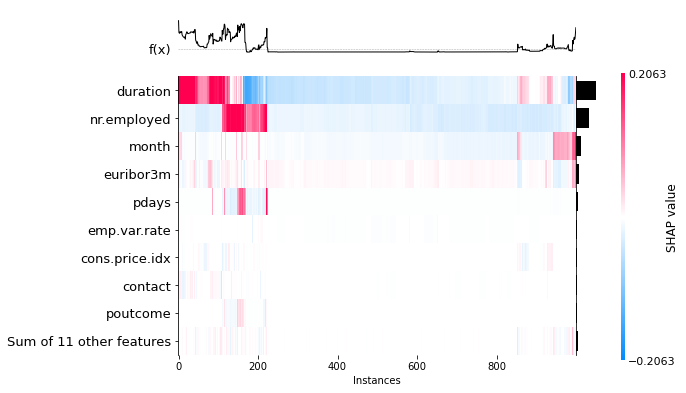

In [25]:
shap_values_all = explainer(X_train.iloc[:1000,:])
shap.initjs() # для работы в колаборатории 

shap.plots.heatmap(shap_values_all)

In [ ]:
По тепловой карте видно, что наиболее значимое влияние оказывает длительность разговора и количество сотрудинков. 
Интересно, что диаграмма указывает на определённую область с высокими значениями целевой функцией, но другой комбинацией параметров.